In [30]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, year, explode, lower, size, array_contains
from pymongo import MongoClient
import findspark
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
print(sys.executable)

C:\Users\linl8\AppData\Local\Programs\Python\Python313\python.exe


In [3]:
# Connect to MongoDB
client = MongoClient("localhost", 27017)
db = client["project"]

genre_col = db["Genre"]
movies_col = db["Movies"]
spotify_col = db["Spotify_Data"]
spotify_clean_col = db["Spotify_Data_Clean"]

In [4]:
import os

# Set up full environment
os.environ["SPARK_HOME"] = "C:\\spark"
os.environ["HADOOP_HOME"] = "C:\\spark"
os.environ["JAVA_HOME"] = "C:\\Program Files\\Java\\jdk-1.8" 
os.environ["PATH"] = f"{os.environ['SPARK_HOME']}\\bin;{os.environ['JAVA_HOME']}\\bin;" + os.environ["PATH"]

os.environ["PYSPARK_PYTHON"] = "C:\\Users\\linl8\\AppData\\Local\\Programs\\Python\\Python313\\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = "C:\\Users\\linl8\\AppData\\Local\\Programs\\Python\\Python313\\python.exe"


In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MongoSparkConnector") \
    .master("local[*]") \
    .config("spark.jars", ",".join([
        "file:///C:/spark/jars/mongo-spark-connector_2.12-3.0.1.jar",
        "file:///C:/spark/jars/mongodb-driver-sync-4.2.3.jar",
        "file:///C:/spark/jars/mongodb-driver-core-4.2.3.jar",
        "file:///C:/spark/jars/bson-4.2.3.jar"
    ])) \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/project") \
    .getOrCreate()

In [6]:
spark

In [7]:
spark._jvm.org.mongodb.spark.MongoSpark

In [8]:
Genre_df = spark.read.format("mongo") \
    .option("uri", "mongodb://localhost:27017") \
    .option("database", "project") \
    .option("collection", "Genre") \
    .load()

Movies_df = spark.read.format("mongo") \
    .option("uri", "mongodb://localhost:27017") \
    .option("database", "project") \
    .option("collection", "Movies") \
    .load()


In [9]:
def fast_parse(doc):
    items = doc.get('album_details', {}).get('tracks', {}).get('items', [])
    duration_total = sum(track.get('duration_ms', 0) for track in items)

    return {
        'Movie_Title': doc.get('movie_title'),
        'Soundtrack_Popularity': doc.get('album_details', {}).get('popularity'),
        'Total_Tracks': doc.get('album_info', {}).get('total_tracks'),
        'Artists': doc.get('album_info', {}).get('artists'),
        'Total_Soundtrack_Duration_ms': duration_total
    }

# Pull, clean, write back
# docs = list(spotify_col.find({}, {"_id": 0}))
# parsed = [fast_parse(d) for d in docs]

# Optional: clean artist names before saving
def extract_artist_names(artists):
    if isinstance(artists, list):
        names = []
        for artist in artists:
            if isinstance(artist, dict):
                names.append(artist.get('name', ''))
            elif isinstance(artist, str):
                names.append(artist)
        return ', '.join(filter(None, names))
    elif isinstance(artists, dict):
        return artists.get('name', '')
    elif isinstance(artists, str):
        return artists
    return ''

#for doc in parsed:
    #doc["Artists"] = extract_artist_names(doc["Artists"])

# Save cleaned data into new MongoDB collection
# spotify_clean_col.insert_many(parsed)

In [10]:
Spotify_df = spark.read.format("mongo") \
    .option("uri", "mongodb://localhost:27017") \
    .option("database", "project") \
    .option("collection", "Spotify_Data_Clean") \
    .load()

In [20]:
# Get Genre ID by name
def get_genre_id(genre_name: str):
    genres_df = Genre_df.select(explode("genres").alias("genre"))
    result = genres_df.filter(lower(col("genre.name")) == genre_name.lower()).select("genre.id").collect()
    return result[0]["id"] if result else None

def get_all_genre_names():
    genres_df = Genre_df.select(explode("genres").alias("genre"))
    names = genres_df.select("genre.name").distinct().orderBy("genre.name").collect()
    return [row["name"] for row in names]

get_all_genre_names()

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western']

In [21]:
# Average Movie Statistics in Genre
def average_stats(genre_id):
    filtered = Movies_df.filter(array_contains(col("genre_ids"), genre_id))
    
    stats = filtered.agg(
        avg("vote_average").alias("Movie_Avg_Rating"),
        avg("vote_count").alias("Movie_Avg_VoteCount"),
        avg("popularity").alias("Movie_Avg_Popularity"),
        count("*").alias("Total_Movie_Counts")
    ).collect()

    return stats[0].asDict() if stats else None
average_stats(12)

{'Movie_Avg_Rating': 4.1488339724791325,
 'Movie_Avg_VoteCount': 300.9524926686217,
 'Movie_Avg_Popularity': 1.0911748071283565,
 'Total_Movie_Counts': 22165}

In [22]:
from pyspark.sql.functions import col, array_contains, year, to_date, avg, count

# Timeline Data for each genre
def genre_timeline(genre_id):
    # Filter movies that contain the genre ID and have a valid release_date
    filtered = Movies_df.filter(
        (array_contains(col("genre_ids"), genre_id)) &
        (col("release_date").isNotNull())
    )

    # Convert release_date to date and extract year
    with_year = filtered.withColumn("release_year", year(to_date(col("release_date"), "yyyy-MM-dd")))

    # Group by year and compute averages and count
    result = with_year.groupBy("release_year").agg(
        avg("vote_average").alias("Movie_Avg_Rating"),
        avg("popularity").alias("Movie_Avg_Popularity"),
        count("*").alias("Total_Movie_Counts")
    ).orderBy("release_year")

    return result

timeline_df = genre_timeline(12)
timeline_df.show()

+------------+------------------+--------------------+------------------+
|release_year|  Movie_Avg_Rating|Movie_Avg_Popularity|Total_Movie_Counts|
+------------+------------------+--------------------+------------------+
|        1950| 4.237833333333334|  0.5227010416666666|                96|
|        1951| 4.295080459770115|  0.5501367816091953|                87|
|        1952| 4.132264957264957|  0.4794264957264956|               117|
|        1953| 4.367905797101449|  0.5181978260869564|               138|
|        1954| 4.288606557377048|  0.5156327868852459|               122|
|        1955| 4.589548872180451|  0.3834060150375941|               133|
|        1956|3.7004615384615382|  0.5367890109890111|                91|
|        1957| 4.240575471698113|  0.3596688679245282|               106|
|        1958| 3.864299270072992| 0.39163138686131377|               137|
|        1959| 4.241273972602739|  0.5930130136986308|               146|
|        1960|3.6519761904761916|  0.5

In [25]:
# Get the top 10 rated movie for specific genre
def get_top_10_movies(genre_id):
    # Get top movies by genre
    top_movies_df = Movies_df.filter(
        (array_contains(col("genre_ids"), genre_id)) &
        (col("vote_count") > 10000)
    ).select("title", "vote_average", "vote_count") \
     .orderBy(col("vote_average").desc()) \
     .limit(25)

    # Collect movie titles
    top_titles = [row['title'].lower() for row in top_movies_df.collect()]

    #  Filter soundtracks that match top titles
    filtered_soundtracks = Spotify_df \
        .withColumn("title_lower", lower(col("Movie_Title"))) \
        .filter(lower(col("Movie_Title")).isin(top_titles)) \
        .select("Movie_Title", "Soundtrack_Popularity", "Total_Tracks", "Total_Soundtrack_Duration_ms", "Artists")

    # Convert both to pandas
    top_movies_pd = top_movies_df.toPandas()
    soundtracks_pd = filtered_soundtracks.toPandas()

    # Prepare for join
    top_movies_pd["title_lower"] = top_movies_pd["title"].str.lower()
    soundtracks_pd["title_lower"] = soundtracks_pd["Movie_Title"].str.lower()

    # Merge, drop NaNs, and drop duplicates
    merged = pd.merge(top_movies_pd, soundtracks_pd, on="title_lower", how="left")
    merged = merged.dropna()
    merged = merged.drop_duplicates(subset=["title"])
    merged = merged.sort_values(by="vote_average", ascending=False).head(10)
    corr = merged['vote_average'].corr(merged['Soundtrack_Popularity'])

    return merged.drop(columns=["title_lower", "title"]).to_dict("records")
    
get_top_10_movies(12)

[{'vote_average': 8.482,
  'vote_count': 24966,
  'Movie_Title': 'The Lord of the Rings: The Return of the King',
  'Soundtrack_Popularity': 61.0,
  'Total_Tracks': 53.0,
  'Total_Soundtrack_Duration_ms': 12844690.0,
  'Artists': 'The Lord Of The Rings - The Return Of The King - The Complete Recordings',
  'corr': 0.572431782822588},
 {'vote_average': 8.454,
  'vote_count': 36942,
  'Movie_Title': 'Interstellar',
  'Soundtrack_Popularity': 75.0,
  'Total_Tracks': 30.0,
  'Total_Soundtrack_Duration_ms': 8362282.0,
  'Artists': 'Hans Zimmer',
  'corr': 0.572431782822588},
 {'vote_average': 8.419,
  'vote_count': 25867,
  'Movie_Title': 'The Lord of the Rings: The Fellowship of the Ring',
  'Soundtrack_Popularity': 66.0,
  'Total_Tracks': 18.0,
  'Total_Soundtrack_Duration_ms': 4287755.0,
  'Artists': 'Howard Shore',
  'corr': 0.572431782822588},
 {'vote_average': 8.403,
  'vote_count': 22475,
  'Movie_Title': 'The Lord of the Rings: The Two Towers',
  'Soundtrack_Popularity': 60.0,
  'To

Correlation between movie rating and soundtrack popularity: 0.572


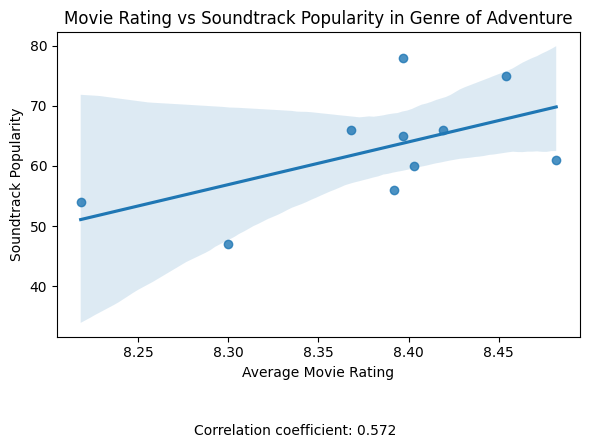

In [34]:
merged_list = get_top_10_movies(12)
merged_df = pd.DataFrame(merged_list)
correlation = merged_df['vote_average'].corr(merged_df['Soundtrack_Popularity'])
print(f"Correlation between movie rating and soundtrack popularity: {correlation:.3f}")

plt.figure(figsize=(6, 4))
sns.regplot(x='vote_average', y='Soundtrack_Popularity', data=merged_df)
plt.title("Movie Rating vs Soundtrack Popularity in Genre of Adventure")
plt.xlabel("Average Movie Rating")
plt.ylabel("Soundtrack Popularity")
plt.tight_layout()
plt.figtext(0.5, -0.1, f"Correlation coefficient: {correlation:.3f}", wrap=True, ha='center', fontsize=10)
plt.show()

In [26]:
# Find the average soundtrack aount for specific genre
def average_soundtrack_amount(genre_id):
    # Lowercase movie titles
    movies = Movies_df.withColumn("title_lower", lower(col("title")))
    soundtracks = Spotify_df.withColumn("title_lower", lower(col("Movie_Title")))

    # Filter movies by genre
    filtered_movies = movies.filter(array_contains(col("genre_ids"), genre_id))

    # Join with soundtrack data on title_lower
    joined = filtered_movies.join(
        soundtracks.select("title_lower", "Total_Tracks"),
        on="title_lower",
        how="inner"
    )

    # Calculate average number of tracks
    if joined.rdd.isEmpty():
        return 0
    avg_tracks_row = joined.agg(avg("Total_Tracks").alias("avg_tracks")).first()

    return round(avg_tracks_row["avg_tracks"], 2) if avg_tracks_row["avg_tracks"] is not None else None
    
average_soundtrack_amount(12)

12.09

In [29]:
from pyspark.sql.functions import lower, explode, split, array_contains, col, count, trim

def get_top_composers(genre_id):
    # Lowercase titles
    movies = Movies_df.withColumn("title_lower", lower(col("title")))
    soundtracks = Spotify_df.withColumn("title_lower", lower(col("Movie_Title")))

    # Filter movies by genre
    filtered_movies = movies.filter(array_contains(col("genre_ids"), genre_id)) \
                            .select("title_lower")

    # Join with soundtracks
    joined = filtered_movies.join(
        soundtracks.select("title_lower", "Artists"),
        on="title_lower",
        how="inner"
    ).filter(col("Artists").isNotNull())

    # Split and explode artists
    exploded = joined.withColumn("Composer", explode(split(col("Artists"), ",")))
    cleaned = exploded.withColumn("Composer", trim(col("Composer")))

    # Group and count
    ranked = cleaned.groupBy("Composer").agg(count("*").alias("count")) \
                    .orderBy(col("count").desc()) \
                    .limit(5)

    return ranked.toPandas().to_dict("records")
